# Using LSTM's to predict the future



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## Define an LSTM based model
Below we define a simple network using one LSTM layer with 50 neurons and then a Dense layer to map to a single output. This network will be able to handle a sequence input and give back a single value sequence output (since there is one neuron in the Dense layer) 

In [2]:
#Define
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(None,1),return_sequences=False)) # LSTM layer with 50 neurons
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


## Define a function to model
Here we will pick a simple combination of sine function and an exponential. Then we will generate a sequence of x and y values.

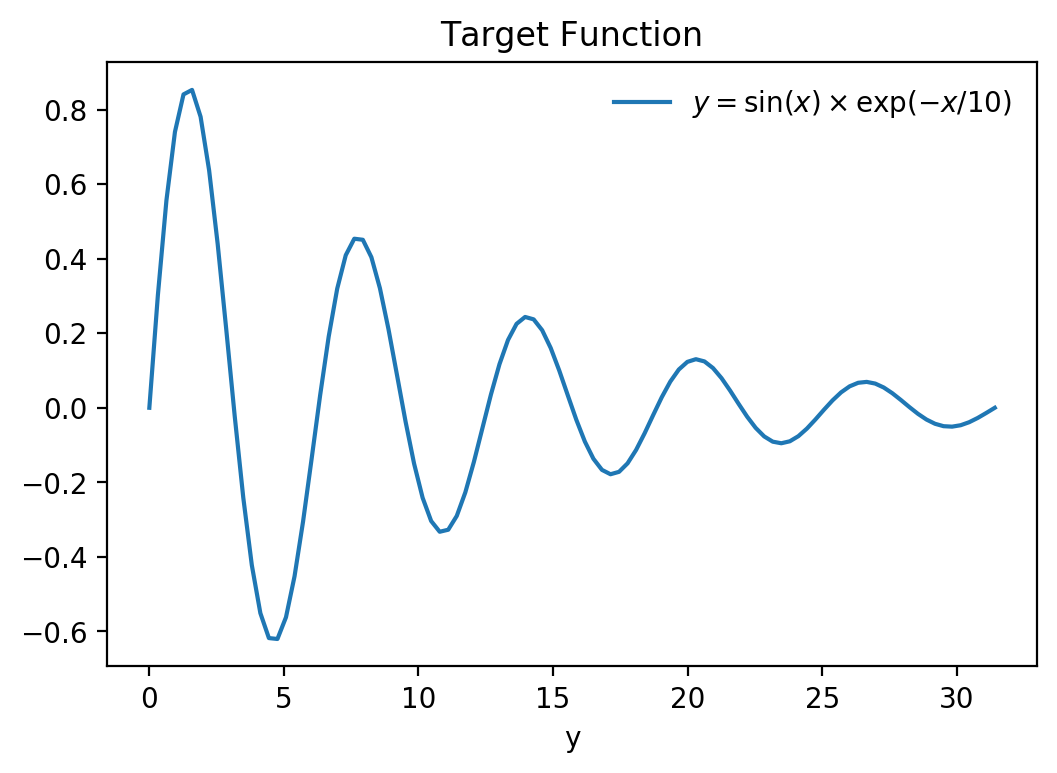

In [3]:

def sinexp(x):
    return np.sin(x)*np.exp(-x/10)

numPoints=100
x=np.linspace(0,10*np.pi,numPoints)
y=sinexp(x)
fig,ax=plt.subplots()
ax.plot(x,y,label=r"$y=\sin(x) \times \exp(-x/10)$")
ax.set_xlabel("x")
ax.set_xlabel("y")
ax.set_title("Target Function")
ax.legend()

## How to predict the future?
There are a number of ways we could try and train our LSTM to predict the future. Currently we have an array of $y$ data values. But how do we feed this into a model and use it to predict something. We need to define a few dimensions. How many steps do we want to include in the training data (window size) and how far into the future do we want to predict (offset)?


In [4]:
windowsize=10
offset=10 #How many samples into the future to predict


samp=np.arange(numPoints)
sampInput= [samp[i : i + windowsize] for i in range(len(samp)-(windowsize+offset)+1)]
sampLabel= [samp[i +windowsize : i+ windowsize+offset] for i in range(len(samp)-(windowsize+offset)+1)]
for i in range(5):
    print(i,sampInput[i],sampLabel[i])

numPoints=100
def shapeArray(x,windowsize,offset):
    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)
    
xInput,xLabel=shapeArray(x,windowsize,offset)
for i in range(5):
    print(i,xInput[i],xLabel[i])

yInput=sinexp(xInput)
yLabel=sinexp(xLabel)


print(yInput.shape)
print(yLabel.shape)

0 [0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
1 [ 1  2  3  4  5  6  7  8  9 10] [11 12 13 14 15 16 17 18 19 20]
2 [ 2  3  4  5  6  7  8  9 10 11] [12 13 14 15 16 17 18 19 20 21]
3 [ 3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18 19 20 21 22]
4 [ 4  5  6  7  8  9 10 11 12 13] [14 15 16 17 18 19 20 21 22 23]
0 [0.         0.31733259 0.63466518 0.95199777 1.26933037 1.58666296
 1.90399555 2.22132814 2.53866073 2.85599332] [3.17332591 3.4906585  3.8079911  4.12532369 4.44265628 4.75998887
 5.07732146 5.39465405 5.71198664 6.02931923]
1 [0.31733259 0.63466518 0.95199777 1.26933037 1.58666296 1.90399555
 2.22132814 2.53866073 2.85599332 3.17332591] [3.4906585  3.8079911  4.12532369 4.44265628 4.75998887 5.07732146
 5.39465405 5.71198664 6.02931923 6.34665183]
2 [0.63466518 0.95199777 1.26933037 1.58666296 1.90399555 2.22132814
 2.53866073 2.85599332 3.17332591 3.4906585 ] [3.8079911  4.12532369 4.44265628 4.75998887 5.07732146 5.39465405
 5.71198664 6.02931923 6.34665183 6.663984

## Training the network
Now we need to train our model. Again there are many ways we could choose to do this. Here we will pick a random starting $x_0$ and then generate 100 points from that starting position. 

100%|██████████| 200/200 [00:01<00:00, 187.02it/s]


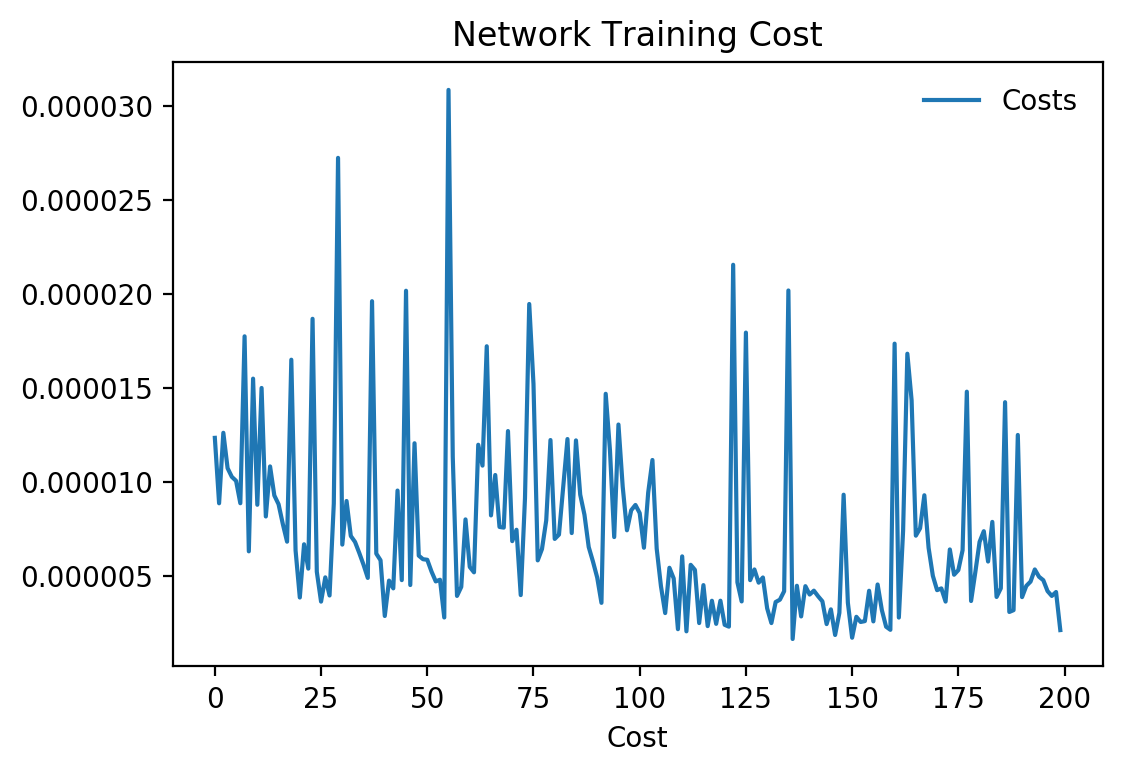

In [13]:
steps=200
costs=np.zeros(steps)
for i in tqdm(range(steps)):
    x0=np.random.uniform(low=0,high=5)  #Pick random start point
    x=np.linspace(x0,x0+10*np.pi,numPoints) #generate 1000 points from that start posiiton
    xInput,xLabel=shapeArray(x,windowsize,offset)

    yInput=sinexp(xInput)
    yLabel=sinexp(xLabel)
    y_in=yInput.reshape(yInput.shape[0],yInput.shape[1],1)  # Reshape the input array to have the dimensions (batchsize,time samples, features)
    y_target=yLabel[:,-1].reshape(yLabel.shape[0],1) # Reshape the output array to have the dimensions (batchsize, time samples)
    costs[i]=model.train_on_batch(y_in,y_target) #Train the network
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_xlabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

## Network performance

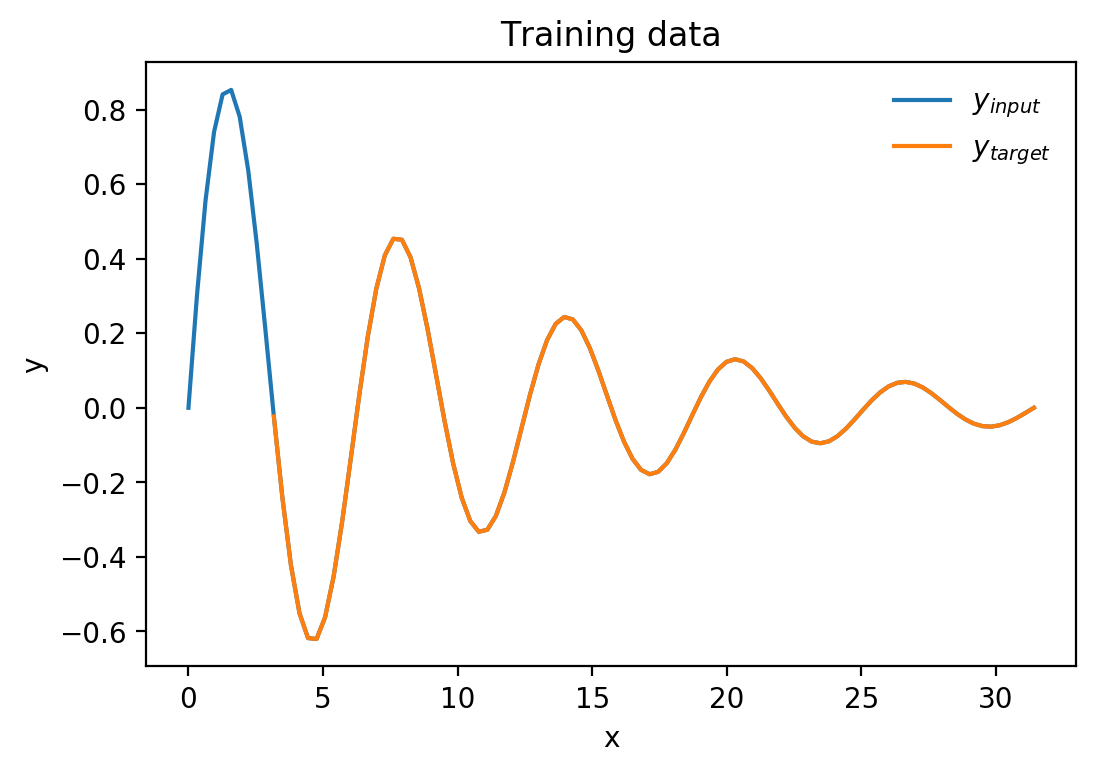

In [10]:
x_test=np.linspace(0,10*np.pi,numPoints)
y_test=sinexp(x_test)
y_testoff=sinexp(x_test[offset:])
fig,ax=plt.subplots()
samps=np.arange(0,numPoints-offset)
ax.plot(x_test,y_test,label=r"$y_{input}$")
ax.plot(x_test[offset:],y_testoff,label=r"$y_{target}$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Training data")
ax.legend()

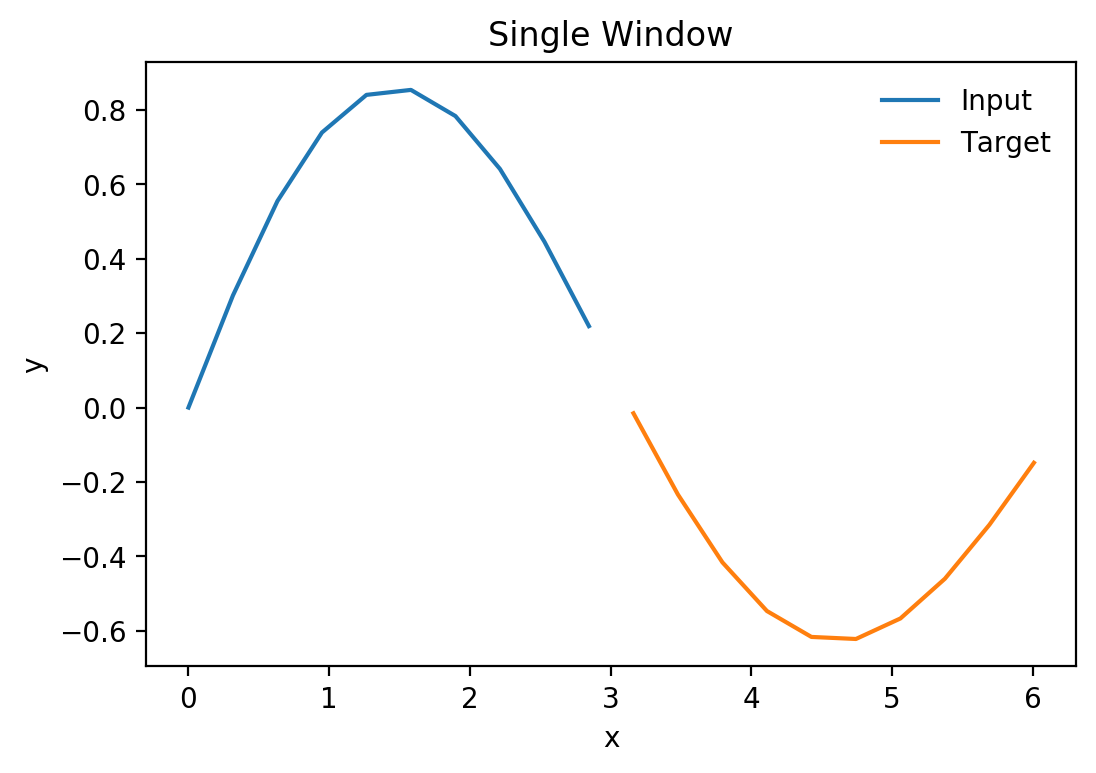

In [11]:
#Note that our network has been trained on a particular dx between samples if we don't use this it will not work well!
#Predict over a larger phase space from 0 ->15pi instead of 0->10pi
numTestPoints=150
x_test=np.linspace(0,15*np.pi,numTestPoints)
y_test=sinexp(x_test)
y_testoff=sinexp(x_test[offset:])
test_samps=np.arange(0,numTestPoints-offset)
xTest_in,xTest_label=shapeArray(x_test,windowsize,offset)
yTest_in=sinexp(xTest_in)
yTestLabel=sinexp(xTest_label)


fig,ax=plt.subplots()
ax.plot(xTest_in[0],yTest_in[0],label="Input")
ax.plot(xTest_label[0],yTestLabel[0],label="Target")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Single Window")
ax.legend()
#np.shape(yTest_in)



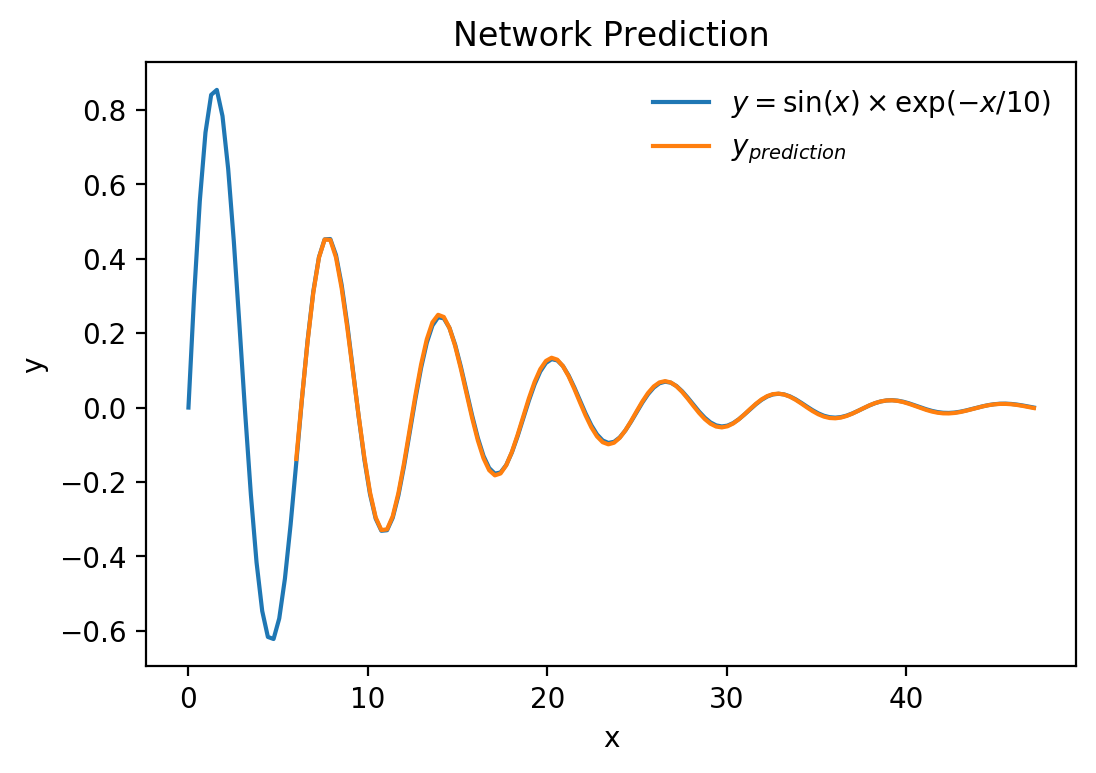

In [12]:

yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))

fig,ax=plt.subplots()
ax.plot(x_test,y_test,label=r"$y=\sin(x) \times \exp(-x/10)$")
#ax.plot(x_test[offset:],y_testoff,label=r"$y_{target}$")
ax.plot(x_test[windowsize+offset-1:],y_hat.reshape(y_hat.shape[0]),label=r"$y_{prediction}$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Network Prediction")
ax.legend()